We'll need a number of different packages for what we're doing with the data.

It's normally good practice to try and import your packages at the top of a script (or in this case, notebook).

In [1]:
from glob import glob


import scipy
import re

import numpy as np

import matplotlib.pyplot as plt
from math import floor, ceil

| Package | Why it's imported |
|---------|-------------------|
| glob    | Used to find files using wildcard expressions. |
| scipy   | Used for various science operations such as data interpolation. |
| re      | *Regular expressions* - Used to extract data from strings with a standard format. |
| numpy   | Linear algebra and array manipulation |
| matplotlib | Plotting | 
| math | Advanced math functions (here rounding up and down by `ceil` and `floor`. |

In [2]:
import astropy
from astropy.coordinates import SkyCoord, ICRS, EarthLocation, AltAz, GCRS, FK5
import astropy.units as u
from astropy.time import Time

In [3]:
import jplephem
from jplephem.spk import SPK

| Package | Why it's imported |
|---------|-------------------|
| astropy | Lots of useful astronomy data functions |
| astropy.coordinates | Handling and transforming astronomical coordinates and geometry |
| astropy.units | For handling physical units on quantities |
| astropy.time | For handling times and timezones. |
| jplephem | Used to calculate the position and velocity of objects in the solar system (the Earth, for what we need here) |

In [4]:
import xarray as xr

/home/daniel/.virtualenvs/IGRlaptop21/sandbox/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


| Package | Why it's imported |
|---------|-------------------|
| xarray  | For handling large and complex arrays of data. |

# Opening raw archival data

This tutorial will start by showing you how to manipulate the raw archival data from previous years' labs.

First just set up the location of the data.
All of the archival data is stored on the `cassegrain` machine.

In [5]:
datadir = "/home/daniel/data/radio/srt2017/"

Now let's make a glob of all of the data files. The `glob` searches for any file on the file system which matches a given pattern: we can use an asterisk to match everything. This example uses the `datadir` as the root location to look for files, and then searches for files which end with the extension `.dat`. 

In [6]:
files = glob("{}*.dat".format(datadir))

The raw data doesn't contain any metadata in the file itself.

There is some metadata in the file name, however, and these have the format

`ra<RA>dec<DEC>time<TIME>.dat`

We can use *regular expressions* to extract these data from the fiename.

The `extract_metadata` function provides a basic example of how to do this, and converts the data extracted from the filename into `astropy` objects which we can use later in the analysis.

In [7]:
def extract_metadata(filename):
    """
    Extract all of the meta data contained within the name of a data file.
    
    Parameters
    ----------
    filename : str
        The name of the file, can optionally include the full path, 
        in which case the name is taken to be everything after the final
        slash.
        
    Returns
    -------
    position : `astropy.skycoord`
        The sky position at which the file starts
    time : `astropy.Time`
        The time at which the file starts.
    """
    
    a = re.compile("ra(.*)dec(.*)time(.*).dat")
    filepath = filename.split('/')

    s_ra = float(a.search(filepath[-1]).group(1))
    s_dec = float(a.search(filepath[-1]).group(2))
    s_time = a.search(filepath[-1]).group(3)
    
    
    time = Time(s_time, format='isot', scale='utc')
    position = SkyCoord(s_ra*u.deg, s_dec*u.deg, frame=ICRS, obstime = time)
    return position, time

Some of the metadata isn't included in the filename, and we need to provide this to the program here.
It would be sensible to include a machine readable file, or at least a `README` file in the directory with the data to include these of course.

The additional data which we need is

| Quantity    | Description |
|-------------|-------------|
| `bandwidth` | The bandwidth of the detector which collected the data. | 
| `centre`    | The central frequency which the detector was tuned to.  |
| `frequencies` | An array corresponding to each frequency bin in the spectrum. |
| `observatory` | The coordinates of the observatory. |

In [8]:
bandwidth = 4e6 * u.hertz
centre = 1420.4e6 * u.hertz

frequencies = np.linspace(centre - bandwidth/2, centre + bandwidth/2, 256)

acre_road = EarthLocation(lat=55.9024278*u.deg, lon=-4.307582*u.deg, height=61*u.m)

# Calculating doppler correction

We need to correct the spectra for the movement of the observatory within the Galaxy.
This means transforming the spectrum into a locally inertial frame, called the *LSR*, the local standard of rest, which the sun is moving in relative to the rest of the galaxy, and which the Earth is moving in relative to the sun, and in which the obserator is moving relative to the (centre of) the Earth. 

The way that we determine the speed of the sun about the galaxy is the JPL Horizons ephemeris. You'll need to load in the fits to the simulation from a datafile which is stored on `cassegrain`.

In [9]:
kernel = SPK.open('/home/daniel/data/de430.bsp')

In [10]:
@u.quantity_input(canon_velocity=(u.meter / u.second))
def v_sun(source, apex = "18h03m50.29s +30d00m16.8s", 
                  canon_velocity = 20.0 * 1000 * u.meter / u.second):
    """
    Calculate the velocity of the sun relative to a point in the sky.
    
    Parameters
    ----------
    source : `astropy.coordinate.SkyCoord` object
        The point on the sky which the Earth's projected velocity should be 
        calculated for.
        
    apex : str, optional
        The point in the sky which the Sun is travelling towards. This should 
        be given as a string in the format "ra dec". The default value is
        18h03m50.29s +30d00m16.8s.
        
    canon_velocity : float
        The velocity at which the sun is travelling towards `apex`. This 
        defaults to 20 000 m/s. The value must be specified using astropy 
        units.
        
    Returns
    -------
    v_sun : `astropy.quantity`
        The velocity of the sun, relative to the source, with correct units.
    
    Notes
    -----
    The Sun is moving towards a point in the sky close to Vega at a velocity
    of around 20 km/s. In order to calculate the velocity of the Earth towards 
    any other point in the sky we need to project the velocity vector onto
    the position vector of that point in the sky, using a dot product.
    """
    if isinstance(source.obstime.value, str):
        equinox = source.obstime
    else:
        equinox = source.obstime[0]
    c = SkyCoord(apex, equinox="J2000", frame=FK5)
    c = c.transform_to(FK5(equinox=equinox, representation='cartesian'))
    c = c.cartesian
    source = source.cartesian
    v = canon_velocity * c.xyz
    return canon_velocity*np.dot(c.xyz,source.xyz)

def v_obs(source, observer):
    """
    Calculate the velocity of the observatory due to its rotation about the 
    Earth's barycentre in the direction of a point on the sky.
    
    Parameters
    ----------
    source : `astropy.coordinate.SkyCoord` object
        The point on the sky which the Earth's projected velocity should be 
        calculated for.
    observer : `astropy.coordinates.EarthLocation` object
        The location on the Earth of the observatory.
    
    Returns
    -------
    v_obs : `astropy.quantity` object
        The velocity of the observer relative to the source.
    """
    pos = [observer.x.value, observer.y.value, observer.z.value] * u.meter
    vel = [0, 0,  (2*np.pi)/(24.*3600.)]  / u.second # 459
    source = source.transform_to(AltAz(location=observer))
    return np.dot(np.cross(pos, vel), source.cartesian.xyz)*u.meter/u.second

def v_earth(source):
    """
    Calculate the velocity of the Earth relative to some point on the sky.
    
    Parameters
    ----------
    source : `astropy.coordinate.SkyCoord`
        The point on the sky which the Earth's projected velocity should be 
        calculated for.
        
    Returns
    -------
    v_earth : `astropy.quantity` object
        The velocity of the Earth relative to the source.
    """
    time = source.obstime.jd
    position, velocity = kernel[0,3].compute_and_differentiate(time)
    position2, velocity2 = kernel[3,399].compute_and_differentiate(time)
    velocity = velocity - velocity2
    source = source.cartesian
    return np.dot(((velocity * 1000 * u.meter / u.day).to(u.meter / u.second)).T, source.xyz) * u.meter/u.s

def v_lsr(source, observer):
    """
    Calculate the velocity of the local standard of rest for an observatory in
    the direction of a source on the sky.
    
    Parameters
    ----------
    source : `astropy.coordinate.SkyCoord` object
        The point on the sky which the Earth's projected velocity should be 
        calculated for.
    observer : `astropy.coordinates.EarthLocation` object
        The location on the Earth of the observatory.
    
    Returns
    -------
    v_lsr : `astropy.quantity` object
        The velocity of the observer relative to the local standard of rest.
    """
    v =  v_sun(source) + (v_earth(source) + v_obs(source, observer))
    return v



This will allow us to calculate our velocity relative to the source in the local standard of rest frame.

# Converting frequency to velocities

It's conventional in radio astronomy to express the frequency of emission in terms of the velocity required to produce a redshift equivalent to the measured frequency.

In [11]:
import astropy.constants as c

In [12]:
HI_rest_freq = 1420.405 * u.megahertz

In [13]:
# See https://docs.astropy.org/en/stable/api/astropy.units.doppler_radio.html
radio_HI_equiv = u.doppler_radio(HI_rest_freq)

In [14]:
radio_velocity = frequencies.to(u.km/u.s, equivalencies=radio_HI_equiv)

# Converting a frequency spectrum to a Doppler-corrected velocity spectrum

We can then apply all of the doppler corrections to the spectrum.

In [15]:
velocity_axis = np.linspace(500, -500, 303) * u.km/u.s

In [16]:
data = scipy.fromfile(files[0], dtype=np.float32)
position, time = extract_metadata(files[0])

data = np.reshape(data, [-1,256])

roll = int((position.ra/360).value * len(data)/256.0)
data = np.roll(data, roll, axis=0)

(<matplotlib.patches.Rectangle at 0x7ff957212320>,
  <matplotlib.patches.ConnectionPatch at 0x7ff9571d62b0>])

findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


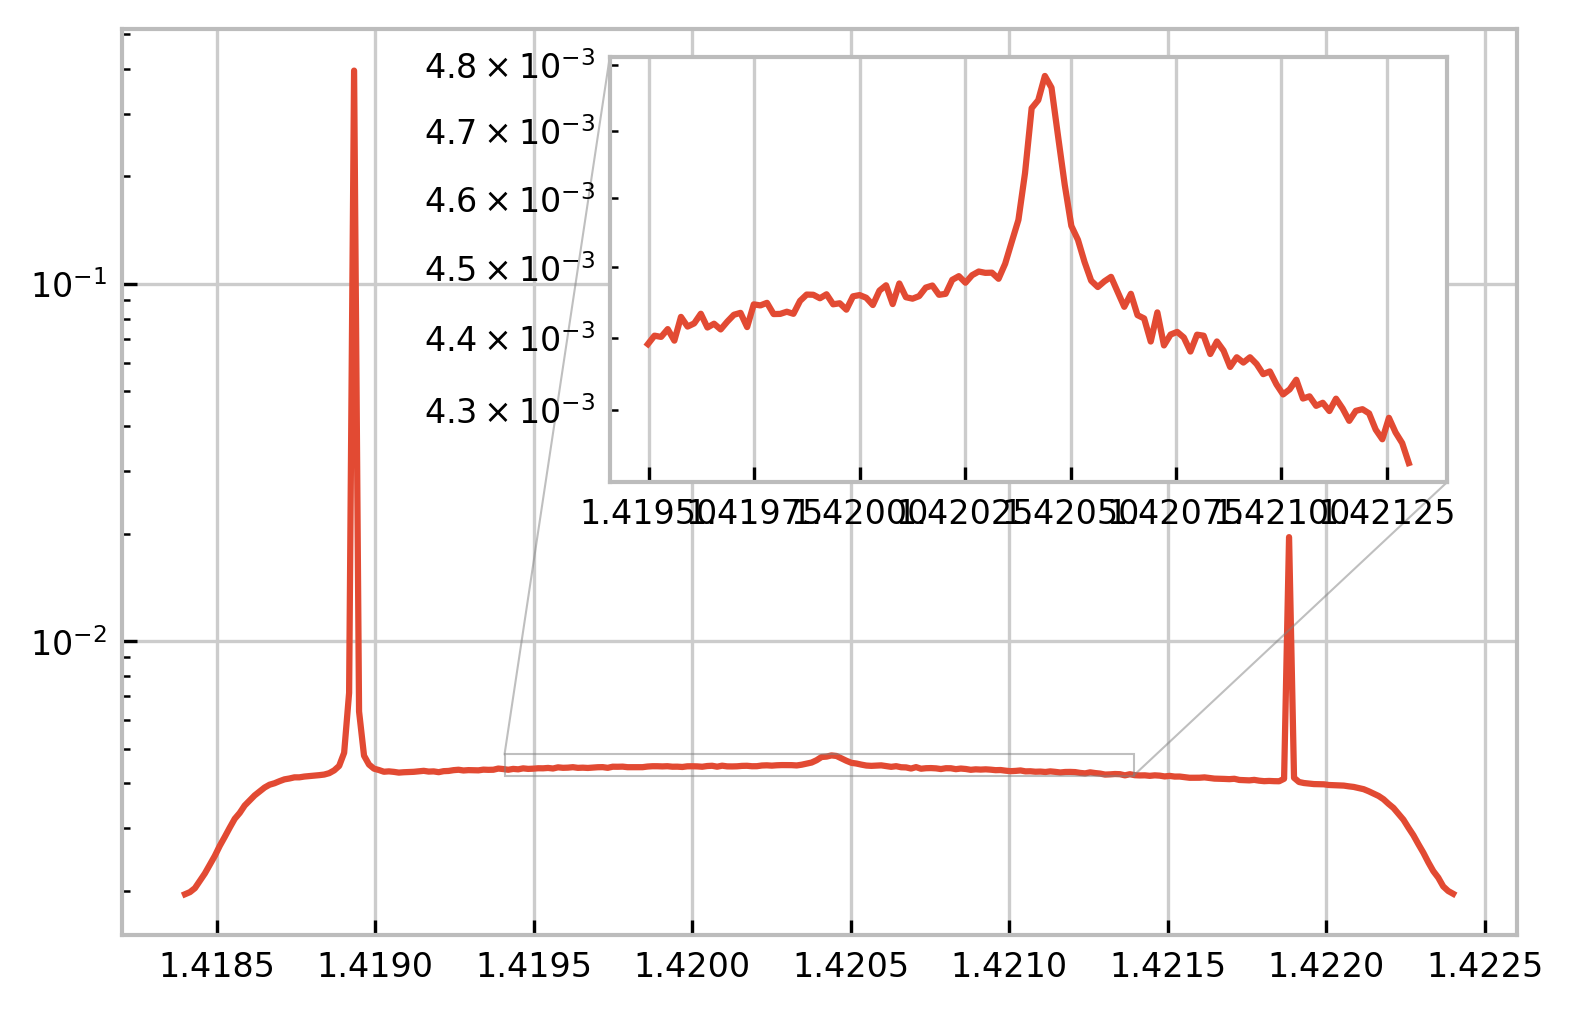

In [17]:
f, ax = plt.subplots(1,1, dpi=300)
ax.semilogy(frequencies/1e9, data[0])
axins = ax.inset_axes([0.35, 0.5, 0.6, 0.47])
axins.semilogy(frequencies[70:-70]/1e9, data[0][70:-70])

ax.indicate_inset_zoom(axins)

In [18]:
obs_freq = frequencies
radio_velocity = obs_freq.to(u.km/u.s, equivalencies=radio_HI_equiv)

In [19]:
source_velocity = radio_velocity - v_lsr(position, acre_road).to(u.km/u.s)

We'll need to re-bin our spectrum so that we can represent the corrected spectrum in the same basis as every other spectrum.

We can do this using linear interpolation.

It's worth noting that numpy can only interpolate on a monotonically *increasing* axis, so we need to reverse the velocity axis.

In [20]:
shifted_spectrum = np.interp(velocity_axis.value[::-1], source_velocity.value[::-1], data[100][::-1])[::-1]

We can roll this all up into a function.

In [21]:
def doppler_correct_spectrum(spectrum, observed_freq, position, 
                             observatory = acre_road,
                             out_min = -500 * u.km/u.s, out_max = 500 * u.km/u.s):
    # transform observed frequencies to observed velocities
    radio_velocity = observed_freq.to(u.km/u.s, equivalencies=radio_HI_equiv)
    
    # Calculate the size of an interval in the new axis
    interval = np.diff(radio_velocity.value)[0] 
    # Then construct that axis
    velocity_axis = np.arange(out_max.value, out_min.value, interval)* u.km/u.s
    
    # Compute the source velocity
    source_velocity = radio_velocity - v_lsr(position, observatory).to(u.km/u.s)
    
    shifted_spectrum = np.interp(velocity_axis.value[::-1], source_velocity.value[::-1], spectrum[::-1])[::-1]
    
    return shifted_spectrum, velocity_axis

# Assembling the data cube

In [22]:
def read_datafile(datafile, spectrum_len = 256):
    
    data = scipy.fromfile(datafile, dtype=np.float32)
    data = np.reshape(data, [-1,spectrum_len])
    
    return data

In [23]:
def integrate_spectra(spectra, times,  old_sample, new_sample):
    """
    Re-integrate observations to increase the total integration time of each spectrum.
    """
    
    integration_factor = int(new_sample / old_sample)
    new_length = floor((data.shape[0]-10) / integration_factor)
    stacked_array = np.reshape(data[10:10+new_length*integration_factor], [new_length, integration_factor, 256])
    integrated_array = np.sum(stacked_array, axis=1)
    
    
    return integrated_array, times[::integration_factor]

In [24]:
list_arrays = []
list_dec= []

In [25]:
calibration = read_datafile("/home/daniel/data/radio/srt2017/calibration.cal")[4:]

In [26]:
for datafile in files:
    data = read_datafile(datafile)
    start_position, start_time = extract_metadata(datafile)

    times = np.linspace(0, 5*(data.shape[0]-1), data.shape[0])
    
    minutes = 6 # corresponding to 1.5 degrees, or half the beam width
    integrated_array, times = integrate_spectra(data, times,  old_sample = 5, new_sample = minutes*60)
    
    times = start_time + times * u.second
    
    if len(times)!=240:continue
    
    start_position_icrs = start_position.copy()
    start_position = start_position.transform_to(AltAz(obstime=times[0], location=acre_road))
    
    positions = [SkyCoord(start_position.az, start_position.alt, frame = AltAz(obstime=time,location=acre_road), unit='deg').transform_to(ICRS) for time in times]
    # Get the vane calibration curve, which has a temperature of 300 K
    # This may not be long enough to match the integration time of the full observation, sp scale it up
    
    calibration_integrated = calibration.sum(axis=0)*((minutes*60)/(calibration.shape[0]*5))
    
    spectrum = (integrated_array / calibration_integrated)
    # This gives a spectrum which is normalised such that 1.0 corresponds to ~ 300K
    
    roll = ceil((start_position_icrs.ra/360).value * len(spectrum))
    spectrum = np.roll(spectrum, roll, axis=0)
    positions = np.roll(positions, roll)
    
    new_axis_len = 303
    
    temp_array = np.ones((spectrum.shape[0], 1, new_axis_len))

    for i, datum in enumerate(spectrum):
        # Perform the new doppler correction here
        datum = doppler_correct_spectrum(datum, frequencies, positions[i])[0]
        temp_array[i, 0, :] = datum

    list_arrays.append(temp_array)
    list_dec.append(positions[0].dec)

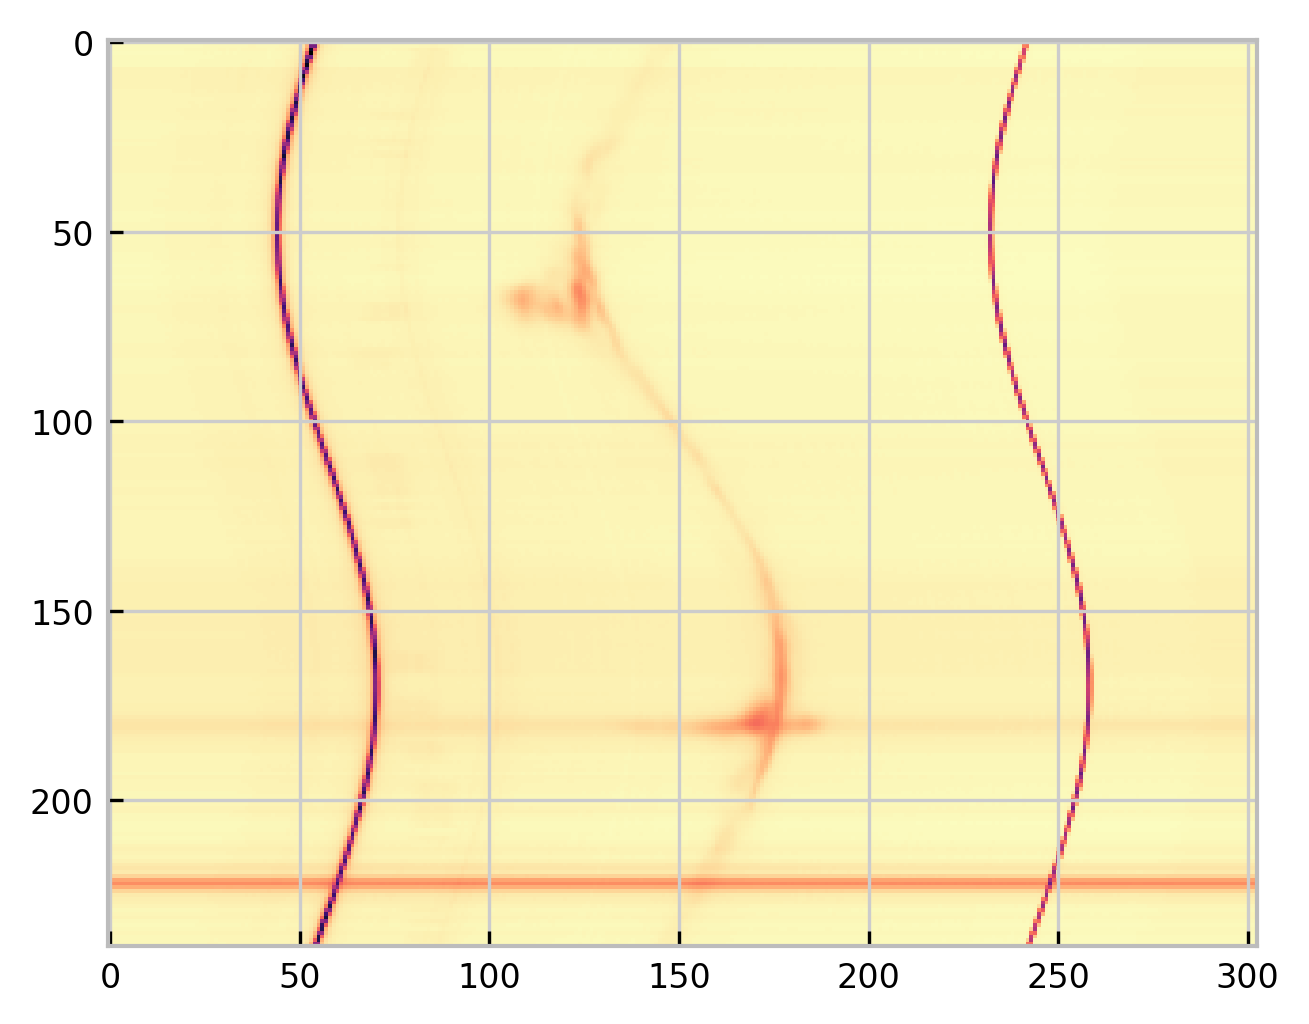

In [29]:
plt.figure(dpi=300)
plt.imshow(temp_array[:,0,:])

In [30]:
xr_cube = xr.DataArray(np.hstack(list_arrays),
                        name="temperature",
                        dims=("ra", "dec", "velocity" ), 
                       coords={"ra": np.linspace(0,360, 239),
                               "dec": [dec.value for dec in list_dec],
                               "velocity": np.linspace(500,-500,303)
                              }
                         # })
                       )

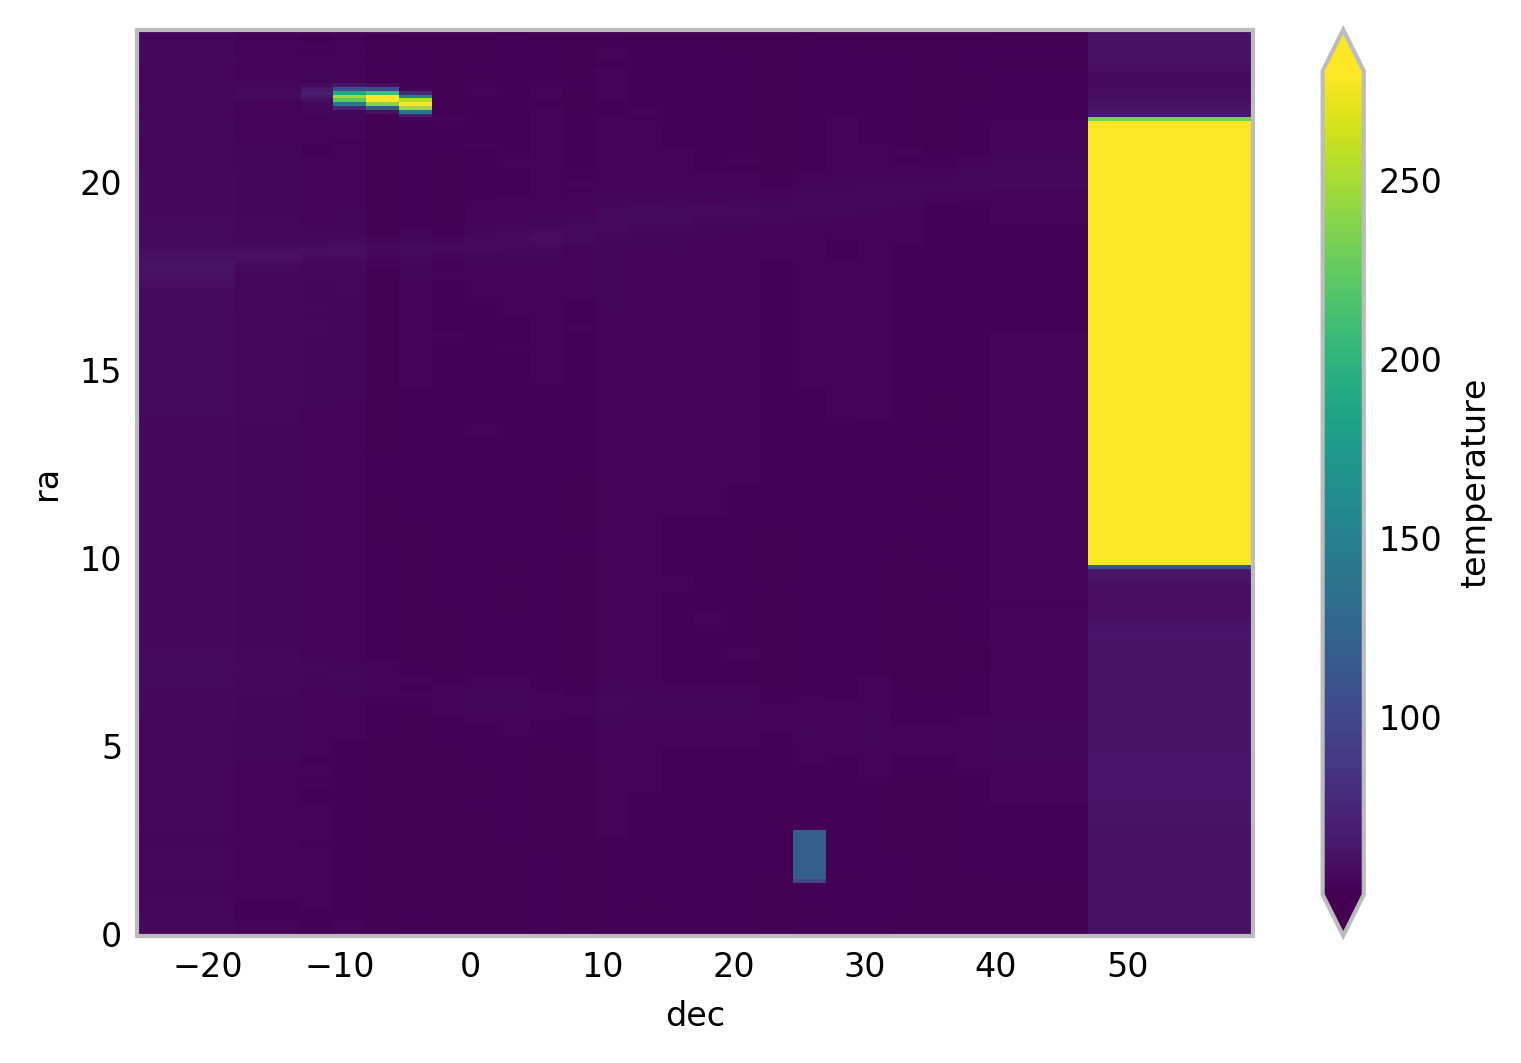

In [31]:
f, ax = plt.subplots(1,1, dpi=300)
xr_cube.coords['ra'] = xr_cube.coords['ra'] / 15
xr_cube.sel(velocity = slice(200, -200)).sum(dim="velocity").sortby(["ra", "dec"]).plot(robust=True, ax=ax,)# vmax=4.2, vmin=3.1)

In [32]:
xr_cube = xr_cube.sortby(["ra", "dec"])
corrected_cube = (xr_cube - xr_cube.isel(ra=100, dec=11))

(-10, 35)

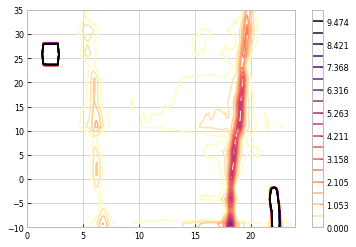

In [34]:

plt.contour(xr_cube.ra, xr_cube.dec, corrected_cube.sel(velocity = slice(200, -200)).sum(dim="velocity").sortby(["ra", "dec"]).T,
           levels = np.linspace(0, 10, 20)
           )
plt.colorbar()
plt.ylim([-10, 35])

# Interpolating the Data onto a regular grid

In [192]:
corrected_cube = corrected_cube.sortby(["ra", "dec"])
resampled_cube = corrected_cube.interp(ra = np.linspace(0, 24, 240), dec = np.arange(-21,55,3))

In [225]:
central_cube = resampled_cube.sel(velocity=slice(200,-200))

# Making a spectral cube

In [193]:
from spectral_cube import SpectralCube

In [194]:
from astropy import wcs

In [227]:
w = wcs.WCS(naxis=3)

In [228]:
w.wcs.crpix = [120.5,8,0]
w.wcs.cdelt = np.array([360/240,
                        3, 
                        np.diff(central_cube.velocity)[0] ])
w.wcs.crval = [180, 
               0,
               central_cube.velocity[0]]
w.wcs.ctype = ["RA---CAR", "DEC--CAR", "VRAD"]

In [249]:
cube = SpectralCube(data=300*central_cube.data.T * u.K, wcs=w)

In [250]:
mask = cube > 0 * u.K

In [251]:
cube = cube.with_mask(mask)

In [252]:
cube

SpectralCube with shape=(121, 26, 240) and unit=K:
 n_x:    240  type_x: RA---CAR  unit_x: deg    range:     0.750000 deg:  359.250000 deg
 n_y:     26  type_y: DEC--CAR  unit_y: deg    range:   -21.000000 deg:   54.000000 deg
 n_s:    121  type_s: VRAD      unit_s: m / s  range:     -201.987 m / s:     195.364 m / s

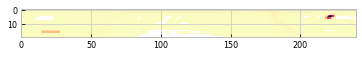

In [282]:
cube[:,:20,:].with_spectral_unit(u.km/u.s).moment(order=0).quicklook()

# Reprojecting the map into galactic coordinates

In [302]:
w2 = cube[:,3:20,:].with_spectral_unit(u.km/u.s).wcs
w2.wcs.ctype[0] = "GLON-CAR"
w2.wcs.ctype[1] = "GLAT-CAR"
#["GLON-CAR", "GLAT-CAR"]
#w2.wcs.crva[[0,1]] = [0, 0]

In [303]:
from reproject import reproject_interp

In [324]:
new_image, footprint = reproject_interp(cube[:,3:20,:].hdu, w2, shape_out=(121,26,240))

In [325]:
gal_cube = SpectralCube(new_image*u.K, w2)
gal_cube = gal_cube.with_mask(mask = gal_cube > 0 * u.K)

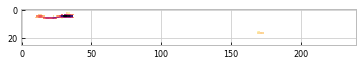

In [329]:
gal_cube[60,:,:].quicklook()

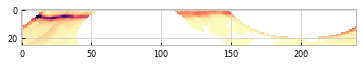

In [307]:
gal_cube.moment(order=0).quicklook()

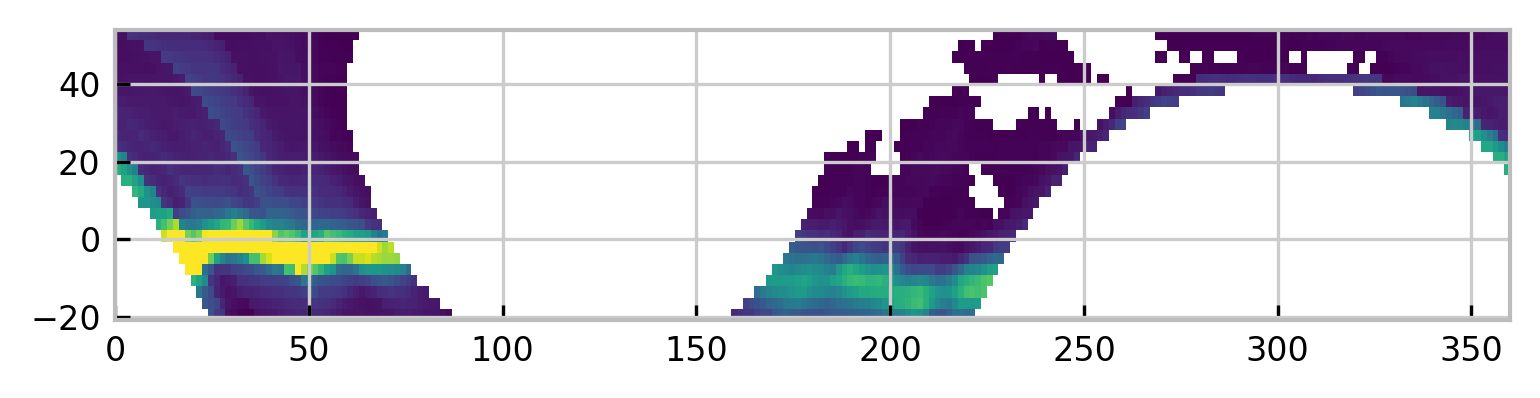

In [334]:
plt.figure(dpi=300)
ax = plt.subplot(1,1,1)
plt.imshow(gal_cube.moment(order=0)[:,:].value, origin='lower', cmap='viridis', extent=(0,360,-21,54), vmax=2500)
#plt.colorbar()
#plt.contour(gal_cube[150,:,:].value)

/home/daniel/.virtualenvs/aries/sandbox/lib/python3.6/site-packages/spectral_cube/masks.py:711: RuntimeWarning: invalid value encountered in greater
  self._comparison_value)
/home/daniel/.virtualenvs/aries/sandbox/lib/python3.6/site-packages/spectral_cube/masks.py:711: RuntimeWarning: invalid value encountered in greater
  self._comparison_value)
/home/daniel/.virtualenvs/aries/sandbox/lib/python3.6/site-packages/spectral_cube/masks.py:711: RuntimeWarning: invalid value encountered in greater
  self._comparison_value)


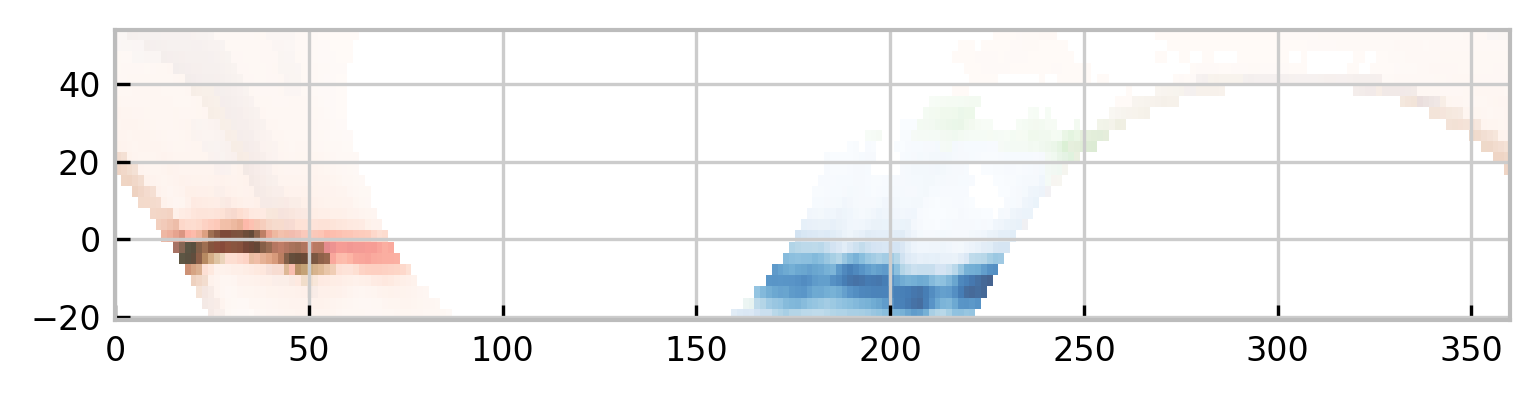

In [435]:
plt.figure(dpi=300)
ax = plt.subplot(1,1,1)
plt.imshow(gal_cube[:55,:,:].moment(order=0)[:,:].value, origin='lower', 
           cmap='Blues', extent=(0,360,-21,54), alpha=0.75)
plt.imshow(gal_cube[55:60,:,:].moment(order=0)[:,:].value, origin='lower', 
           cmap='Greens', extent=(0,360,-21,54), alpha=0.75)
plt.imshow(gal_cube[60:,:,:].moment(order=0)[:,:].value, origin='lower', 
           cmap='Reds', extent=(0,360,-21,54), alpha=0.5)
#plt.colorbar()
#plt.contour(gal_cube[150,:,:].value)

/home/daniel/.virtualenvs/aries/sandbox/lib/python3.6/site-packages/spectral_cube/masks.py:711: RuntimeWarning: invalid value encountered in greater
  self._comparison_value)


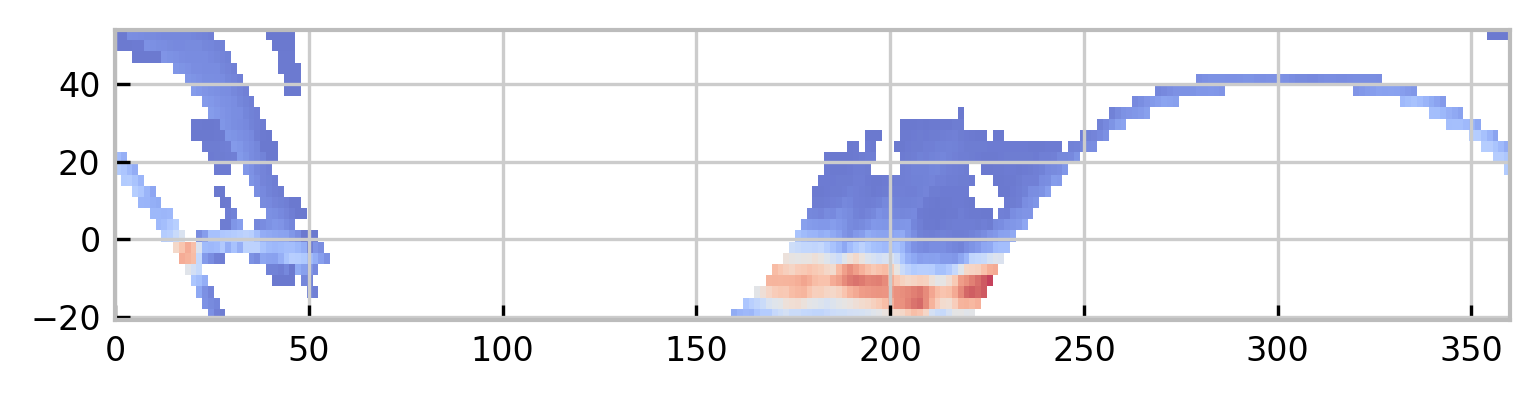

In [436]:
plt.figure(dpi=300)
ax = plt.subplot(1,1,1)
plt.imshow(gal_cube[:55,:,:].moment(order=0)[:,:].value, origin='lower', 
           cmap='coolwarm', extent=(0,360,-21,54), alpha=0.75)
#plt.colorbar()
#plt.contour(gal_cube[150,:,:].value)